In [1]:
import os
import gym
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

## Preprocessing game image 

In [2]:
from skimage.transform import resize
from skimage.color import rgb2gray, gray2rgb
from skimage import img_as_float

In [3]:
from gym.core import ObservationWrapper
from gym.spaces import Box

class PreprocessAtari(ObservationWrapper):
    
    def __init__(self, env):
        ObservationWrapper.__init__(self,env)
        self.img_size = (64,64)
        self.observation_space = Box(0.0, 1.0, (self.img_size[0], self.img_size[1],1))
    
    def _observation(self, img):
        img = img[50:-5, 5:-5]
        img = resize(img, self.img_size)
        img = rgb2gray(img)
        img = np.expand_dims(img,-1)
        img = img_as_float(img)
        img = np.float32(img)
        return img

In [4]:
import gym
env = gym.make('BreakoutDeterministic-v0')
env = PreprocessAtari(env)
observation_shape = env.observation_space.shape
n_actions = env.action_space.n
obs = env.reset()

c:\users\yingg\desktop\myproject0\lib\site-packages\gym\envs\registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: <class '__main__.PreprocessAtari'> doesn't implement 'observation' method. Maybe it implements deprecated '_observation' method.


c:\users\yingg\desktop\myproject0\lib\site-packages\skimage\transform\_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
c:\users\yingg\desktop\myproject0\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


Formal tests seem fine. Here's an example of what you'll get.


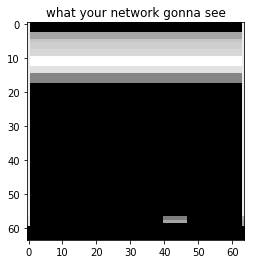

In [5]:
assert obs.ndim == 3
assert obs.shape == observation_shape
assert obs.dtype == 'float32'
assert len(np.unique(obs))>2
assert 0 <= np.min(obs) and np.max(obs) <=1
print("Formal tests seem fine. Here's an example of what you'll get.")

plt.title("what your network gonna see")
plt.imshow(obs[:,:,0],interpolation='none',cmap='gray');

## Frame buffer

In [7]:
from framebuffer import FrameBuffer
def make_env():
    env = gym.make("BreakoutDeterministic-v4")
    env = PreprocessAtari(env)
    env = FrameBuffer(env, n_frames=4, dim_order='tensorflow')
    return env

env = make_env()
env.reset()
n_actions = env.action_space.n
state_dim = env.observation_space.shape

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


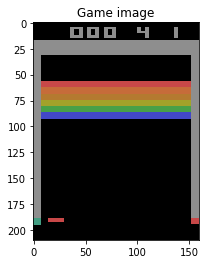

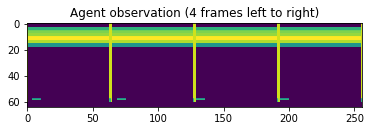

In [9]:
for _ in range(50):
    obs, _, _, _ = env.step(env.action_space.sample())


plt.title("Game image")
plt.imshow(env.render("rgb_array"))
plt.show()
plt.title("Agent observation (4 frames left to right)")
plt.imshow(obs.transpose([0,2,1]).reshape([state_dim[0],-1]));

## Building a network 

In [10]:
import tensorflow as tf
tf.reset_default_graph()
sess = tf.InteractiveSession()

In [11]:
import keras.layers as L
import keras

Using TensorFlow backend.


In [12]:
class DQNAgent:
    
    def __init__(self,name,state_shape,n_actions,epsilon=0,reuse=False):
        with tf.variable_scope(name,reuse=reuse):
            self.network = keras.models.Sequential()
            self.network.add(L.InputLayer(state_shape))
            self.network.add(L.Conv2D(16, (3,3), strides=2, activation='relu'))
            self.network.add(L.Conv2D(32, (3,3), strides=2, activation='relu'))
            self.network.add(L.Conv2D(64, (3,3), strides=2, activation='relu'))
            self.network.add(L.Flatten())
            self.network.add(L.Dense(256, activation='relu'))
            self.network.add(L.Dense(n_actions))
            
            self.state_t = tf.placeholder('float32', [None] + list(state_shape))
            self.qvalues_t = self.get_symbolic_qvalues(self.state_t)
            
        self.weights = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope=name)
        self.epsilon = epsilon

    def get_symbolic_qvalues(self,state_t):
        qvalues = self.network(state_t)
        
        assert tf.is_numeric_tensor(qvalues) and qvalues.shape.ndims == 2, \
            "please return 2d tf tensor of qvalues [you got %s]" % repr(qvalues)
        assert int(qvalues.shape[1]) == n_actions
        
        return qvalues

    def get_qvalues(self, state_t):
        sess=tf.get_default_session()
        return sess.run(self.qvalues_t, {self.state_t: state_t})
    
    def sample_actions(self,qvalues):
        epsilon = self.epsilon
        batch_size, n_actions = qvalues.shape
        random_actions = np.random.choice(n_actions, size=batch_size)
        best_actions = qvalues.argmax(axis=-1)
        should_explore = np.random.choice([0, 1], batch_size, p = [1-epsilon, epsilon])
        return np.where(should_explore, random_actions, best_actions)

In [13]:
agent = DQNAgent("dqn_agent", state_dim, n_actions, epsilon=0.5)
sess.run(tf.global_variables_initializer())

In [14]:
def evaluate(env, agent, n_games=1, greedy=False, t_max=10000):
    """ Plays n_games full games. If greedy, picks actions as argmax(qvalues). Returns mean reward. """
    rewards = []
    for _ in range(n_games):
        s = env.reset()
        reward = 0
        for _ in range(t_max):
            qvalues = agent.get_qvalues([s])
            action = qvalues.argmax(axis=-1)[0] if greedy else agent.sample_actions(qvalues)[0]
            s, r, done, _ = env.step(action)
            reward += r
            if done: break
                
        rewards.append(reward)
    return np.mean(rewards)

In [15]:
evaluate(env, agent, n_games=1)

c:\users\yingg\desktop\myproject0\lib\site-packages\skimage\transform\_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
c:\users\yingg\desktop\myproject0\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


2.0

## Experience replay 

In [16]:
from replay_buffer import ReplayBuffer
exp_replay = ReplayBuffer(10)

for _ in range(30):
    exp_replay.add(env.reset(), env.action_space.sample(), 1.0, env.reset(), done=False)

obs_batch, act_batch, reward_batch, next_obs_batch, is_done_batch = exp_replay.sample(5)

assert len(exp_replay) == 10, "experience replay size should be 10 because that's what maximum capacity is"

In [17]:
def play_and_record(agent, env, exp_replay, n_steps=1):
    """
    Play the game for exactly n steps, record every (s,a,r,s', done) to replay buffer. 
    Whenever game ends, add record with done=True and reset the game.
    :returns: return sum of rewards over time
    
    Note: please do not env.reset() unless env is done.
    It is guaranteed that env has done=False when passed to this function.
    """
    # State at the beginning of rollout
    s = env.framebuffer
    
    # Play the game for n_steps as per instructions above
    # <YOUR CODE>
    
    total_reward = 0.0
    
    for _ in range(n_steps):
        qvalues = agent.get_qvalues([s])
        action = agent.sample_actions(qvalues)[0]
        #print(action)
        next_s, r, done, _ = env.step(action)
        #print(done)
        
        exp_replay.add(s, action, r, next_s, done)
        total_reward +=r
        s = next_s
        
        if done: 
            s = env.reset()
    
    return total_reward

In [18]:
# testing your code. This may take a minute...
exp_replay = ReplayBuffer(20000)

play_and_record(agent, env, exp_replay, n_steps=10000)

# if you're using your own experience replay buffer, some of those tests may need correction. 
# just make sure you know what your code does
assert len(exp_replay) == 10000, "play_and_record should have added exactly 10000 steps, "\
                                 "but instead added %i"%len(exp_replay)
is_dones = list(zip(*exp_replay._storage))[-1]

assert 0 < np.mean(is_dones) < 0.1, "Please make sure you restart the game whenever it is 'done' and record the is_done correctly into the buffer."\
                                    "Got %f is_done rate over %i steps. [If you think it's your tough luck, just re-run the test]"%(np.mean(is_dones), len(exp_replay))
    
for _ in range(100):
    obs_batch, act_batch, reward_batch, next_obs_batch, is_done_batch = exp_replay.sample(10)
    assert obs_batch.shape == next_obs_batch.shape == (10,) + state_dim
    assert act_batch.shape == (10,), "actions batch should have shape (10,) but is instead %s"%str(act_batch.shape)
    assert reward_batch.shape == (10,), "rewards batch should have shape (10,) but is instead %s"%str(reward_batch.shape)
    assert is_done_batch.shape == (10,), "is_done batch should have shape (10,) but is instead %s"%str(is_done_batch.shape)
    assert [int(i) in (0,1) for i in is_dones], "is_done should be strictly True or False"
    assert [0 <= a <= n_actions for a in act_batch], "actions should be within [0, n_actions]"
    
print("Well done!")

Well done!


## Target Networks

In [19]:
target_network = DQNAgent('target_network', state_dim, n_actions)

In [20]:
def load_weights_into_target_network(agent, target_network):
    
    assigns = []
    for w_agent, w_target in zip(agent.weights, target_network.weights):
        assigns.append(tf.assign(w_target, w_agent, validate_shape = True))
    tf.get_default_session().run(assigns)

In [21]:
load_weights_into_target_network(agent, target_network)

sess.run([tf.assert_equal(w, w_target) for w, w_target in zip(agent.weights, target_network.weights)])

[None, None, None, None, None, None, None, None, None, None]

## Learning with Q-learning 

In [22]:
obs_ph = tf.placeholder(tf.float32, shape=(None,) + state_dim)
actions_ph = tf.placeholder(tf.int32, shape=[None])
rewards_ph = tf.placeholder(tf.float32, shape=[None])
next_obs_ph = tf.placeholder(tf.float32, shape = (None,) + state_dim)
is_done_ph = tf.placeholder(tf.float32, shape=[None])

is_not_done = 1 - is_done_ph
gamma = 0.99

In [23]:
current_qvalues = agent.get_symbolic_qvalues(obs_ph)
current_action_qvalues = tf.reduce_sum(tf.one_hot(actions_ph, n_actions) * current_qvalues, axis =1)

In [24]:
next_qvalues_target = target_network.get_symbolic_qvalues(next_obs_ph)
next_state_values_target = tf.reduce_max(next_qvalues_target, axis=1)
reference_qvalues = rewards_ph + gamma * next_state_values_target * is_not_done
td_loss = (current_action_qvalues - tf.stop_gradient(reference_qvalues)) ** 2
td_loss = tf.reduce_mean(td_loss)
train_step = tf.train.AdamOptimizer(1e-4).minimize(td_loss, var_list=agent.weights)

In [25]:
sess.run(tf.global_variables_initializer())

In [24]:
for chk_grad in tf.gradients(reference_qvalues, agent.weights):
    error_msg = 'Reference q-values should have no gradient w.r.t. agent weights. Make sure you used target_network qvalues! '
    error_msg += "If you know what you're doing, ignore this assert."
    assert chk_grad is None or np.allclose(sess.run(chk_grad), sess.run(chk_grad * 0)), error_msg

assert tf.gradients(reference_qvalues, is_not_done)[0] is not None, "make sure you used is_not_done"
assert tf.gradients(reference_qvalues, rewards_ph)[0] is not None, "make sure you used rewards"
assert tf.gradients(reference_qvalues, next_obs_ph)[0] is not None, "make sure you used next states"
assert tf.gradients(reference_qvalues, obs_ph)[0] is None, "reference qvalues shouldn't depend on current observation!" # ignore if you're certain it's ok
print("Splendid!")

Splendid!


##  Main loop

In [34]:
from tqdm import trange
from IPython.display import clear_output
import matplotlib.pyplot as plt
from pandas import DataFrame
moving_average = lambda x, span, **kw: DataFrame({'x':np.asarray(x)}).x.ewm(span=span, **kw).mean().values

%matplotlib inline

mean_rw_history = []
td_loss_history = []

In [35]:
exp_replay = ReplayBuffer(10**5)
play_and_record(agent, env, exp_replay, n_steps=10000)

def sample_batch(exp_replay, batch_size):
    obs_batch, act_batch, reward_batch, next_obs_batch, is_done_batch = exp_replay.sample(batch_size)
    return {
        obs_ph:obs_batch, actions_ph:act_batch, rewards_ph:reward_batch, 
        next_obs_ph:next_obs_batch, is_done_ph:is_done_batch
    }

buffer size = 100000, epsilon = 0.06500


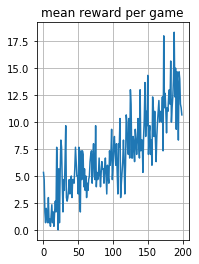

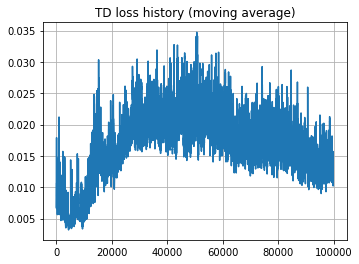

100%|██████████████████████████████████████████| 100000/100000 [35:48:17<00:00,  1.63s/it]


In [36]:
for i in trange(10**5):
    
    # play
    play_and_record(agent, env, exp_replay, 10)
    
    # train
    _, loss_t = sess.run([train_step, td_loss], sample_batch(exp_replay, batch_size=64))
    td_loss_history.append(loss_t)
    
    # adjust agent parameters
    if i % 500 == 0:
        load_weights_into_target_network(agent, target_network)
        agent.epsilon = max(agent.epsilon * 0.99, 0.01)
        mean_rw_history.append(evaluate(make_env(), agent, n_games=3))
    
    if i % 100 == 0:
        clear_output(True)
        print("buffer size = %i, epsilon = %.5f" % (len(exp_replay), agent.epsilon))
        
        plt.subplot(1,2,1)
        plt.title("mean reward per game")
        plt.plot(mean_rw_history)
        plt.grid()

        assert not np.isnan(loss_t)
        plt.figure(figsize=[12, 4])
        plt.subplot(1,2,2)
        plt.title("TD loss history (moving average)")
        plt.plot(moving_average(np.array(td_loss_history), span=100, min_periods=100))
        plt.grid()
        plt.show()